# Music Generation using an LSTM

#### Final Project for Deep Learning (CS 7643)

By Daeil Cha, Daniel Dias, Chitwan Kaudan

### Global Variables

In [1]:
# data_path = "../../lmd_matched"
data_path = "../clean-data"
saved_models_path = "../saved-models"

num_epochs = 10 # 1000
batch_size = 8
num_time_steps = 128
num_total_songs = 400

### Environment

In [2]:
import os

import torch

import numpy as np
import matplotlib.pyplot as plt

# from IPython.core.debugger import set_trace
from getdata import getBatch

%matplotlib inline

%load_ext autoreload
%autoreload 2

learning_rate = 1e-6

##### Pytorch GPU/CPU

In [6]:
# dtype = torch.FloatTensor
# device = torch.device("cpu")

dtype = torch.cuda.FloatTensor
device = torch.device("cuda:0")

print(device)

cuda:0


### Data

#### Load In Data

In [10]:
start = 0
all_data = []

while start < num_total_songs:
    batch = np.array(getBatch(start, batch_size, num_time_steps, data_path), dtype='double')
    all_data.append(batch)
    # Shape should be (batch_size x num_time_steps x note_range x pitch/articulation)
    start += batch_size

all_data = np.concatenate(all_data, axis=0)

In [11]:
all_data.shape

(400, 128, 78, 2)

#### Apply Input Kernel

In [12]:
from model.input_function import InputKernel
inputkernel = InputKernel.apply

note_state_batch = torch.from_numpy(np.swapaxes(all_data,1,2)).float() 
#input kernel expects input shape = batch_size x num_notes x num_timesteps x 2
midi_high = 101
midi_low = 24
time_init=0

with torch.no_grad():
    note_state_batch = inputkernel(note_state_batch,midi_low,midi_high,time_init)

note_state_batch.shape
#input kernel's output shape = batch_size x num_notes x num_timesteps x 80

torch.Size([400, 78, 128, 80])

#### Partition Data

In [13]:
x_train = None
y_train = None

x_val = None
y_val = None

x_test = None
y_test = None

all_expected = np.empty(all_data.shape)
all_expected[:, 0:all_expected.shape[1]-1] = all_data[:, 1:all_data.shape[1]]
all_expected[:, all_expected.shape[1]-1] = 0

all_data = np.reshape(all_data, (num_total_songs, num_time_steps, -1))
all_expected = np.reshape(all_expected, (num_total_songs, num_time_steps, -1))

print("all data:", all_data.shape)
print("all expected:", all_expected.shape)

note_state_batch.requires_grad_()

orig_dataset = torch.utils.data.TensorDataset(note_state_batch.type(torch.FloatTensor), torch.from_numpy(all_expected).type(torch.FloatTensor))
x_train, x_test = torch.utils.data.random_split(orig_dataset, [num_total_songs - 50, 50])

x_train_loader = torch.utils.data.DataLoader(x_train, batch_size=batch_size, shuffle=True)
x_test_loader = torch.utils.data.DataLoader(x_test, batch_size=batch_size)

# for data in x_train_loader:
#     print(data[0].shape, data[1].shape)

all data: (400, 128, 156)
all expected: (400, 128, 156)


## Functions

#### Train Steps

In [3]:
def train_step(x, y, model, loss_criterion, optimizer):
    y_pred = model(x)

    # Compute and print loss
    # loss = loss_criterion(torch.max(y_pred, dim=1).indices, y)
    loss = loss_criterion(y_pred, y)
    loss /= x.shape[0]
    ret_val = loss.item()

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return ret_val

def test_step(x, y, model, loss_criterion):
    y_pred = model(x)
    loss = loss_criterion(y_pred, y)
    loss /= x.shape[0]
    
    return loss.item(), y_pred

#### Save/Load Model

In [4]:
def save_model(model, model_name):
    torch.save(model.state_dict(), os.path.join(saved_models_path, model_name))

def load_model_parameters(model, model_name):
    model.load_state_dict(torch.load(os.path.join(saved_models_path, model_name)))

def load_new_model(model_name, model_constructor, *args):
    model = model_constructor(args)
    load_model_parameters(model, model_name)
    return model

### Model

In [7]:
from model.main_model import MusicGenerationV2

model = MusicGenerationV2(time_sequence_len=num_time_steps, batch_size=batch_size, time_hidden_size=36, data_type=dtype, device=device)

load_model_parameters(model, "biaxial_trained.pt")

loss_criterion = torch.nn.MSELoss(reduction='sum') # = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#### Move To Correct Device

In [8]:
model.to(device)

MusicGenerationV2(
  (lstm_time0): ModuleList(
    (0): LSTM(80, 36, batch_first=True)
    (1): LSTM(80, 36, batch_first=True)
    (2): LSTM(80, 36, batch_first=True)
    (3): LSTM(80, 36, batch_first=True)
    (4): LSTM(80, 36, batch_first=True)
    (5): LSTM(80, 36, batch_first=True)
    (6): LSTM(80, 36, batch_first=True)
    (7): LSTM(80, 36, batch_first=True)
    (8): LSTM(80, 36, batch_first=True)
    (9): LSTM(80, 36, batch_first=True)
    (10): LSTM(80, 36, batch_first=True)
    (11): LSTM(80, 36, batch_first=True)
    (12): LSTM(80, 36, batch_first=True)
    (13): LSTM(80, 36, batch_first=True)
    (14): LSTM(80, 36, batch_first=True)
    (15): LSTM(80, 36, batch_first=True)
    (16): LSTM(80, 36, batch_first=True)
    (17): LSTM(80, 36, batch_first=True)
    (18): LSTM(80, 36, batch_first=True)
    (19): LSTM(80, 36, batch_first=True)
    (20): LSTM(80, 36, batch_first=True)
    (21): LSTM(80, 36, batch_first=True)
    (22): LSTM(80, 36, batch_first=True)
    (23): LSTM(80, 3

## Training

In [9]:
model.train()
best_loss = 30000

num_train_steps = 1760
losses = []

for epoch in range(num_epochs):
    print("Epoch:", epoch)
    losses.append([])

    for i, data in enumerate(x_train_loader, 0):
        x, y = data[0].to(device), data[1].to(device)

        loss = train_step(x, y, model, loss_criterion, optimizer)
        losses[epoch].append(loss)

        print(" -", num_train_steps, ":", loss)
        if num_train_steps % 10 == 0 and loss < best_loss:
            best_loss = loss
            save_model(model, "biaxial_{0}.pt".format(num_train_steps))
            print(" --- saving model to biaxial_{0}.pt ---".format(num_train_steps))
        
        num_train_steps += 1
    losses[epoch] = np.asarray(losses[epoch])
            
save_model(model, "biaxial_trained.pt")

Epoch: 0


NameError: name 'x_train_loader' is not defined

#### Save Model

In [36]:
save_model(model, "biaxial_epochs50.pt")

## Test

In [15]:
model.eval()

y_preds = torch.empty((50, num_time_steps, 78, 2))

with torch.no_grad():
    for i, data in enumerate(x_test_loader, 0):
        x, y = data[0].to(device), data[1].to(device)

        loss, y_pred = test_step(x, y, model, loss_criterion)
        print(loss)
        # y_preds[i:i+y_pred.shape[0]] = y_pred.view(-1, num_time_steps, 78, 2)
        
        for n, temp in enumerate(y_pred):
            temp = temp.view(num_time_steps, 78, 2)
            y_preds[i * y_pred.shape[0] + n] = torch.where(temp > 0.5, torch.ones_like(temp), torch.zeros_like(temp))
            print(len(y_preds[i * y_pred.shape[0] + n].flatten()) - len(torch.nonzero(y_preds[i * y_pred.shape[0] + n])), len(torch.nonzero(y_preds[i * y_pred.shape[0] + n])))

1988.429931640625
19342 626
19344 624
19335 633
19342 626
19346 622
19341 627
19348 620
19351 617
1967.9755859375
19357 611
19350 618
19343 625
19339 629
19338 630
19356 612
19357 611
19347 621
1965.6676025390625
19331 637
19341 627
19340 628
19337 631
19335 633
19342 626
19365 603
19348 620
1943.914794921875
19350 618
19337 631
19352 616
19355 613
19340 628
19346 622
19347 621
19358 610
2052.353759765625
19344 624
19353 615
19349 619
19339 629
19346 622
19341 627
19344 624
19325 643
1762.4678955078125
19338 630
19338 630
19350 618
19346 622
19349 619
19352 616
19350 618
19359 609
2011.3912353515625
19348 620
19342 626


##### IPDB Test Code

In [15]:
# set_trace()

def test_code():
    set_trace()

    train_iter = iter(x_train_loader)
    data = next(train_iter)
    x, y = data[0].to(device), data[1].to(device)    

    loss = train_step(x, y, model, loss_criterion, optimizer)
    
    print(loss)
    
    data = next(train_iter)
    x, y = data[0].to(device), data[1].to(device)

    loss = train_step(x, y, model, loss_criterion, optimizer)
    
    print(loss)
# test_code()

In [26]:
print(len(loss))
for loss in losses:
    print(loss)

TypeError: object of type 'float' has no len()

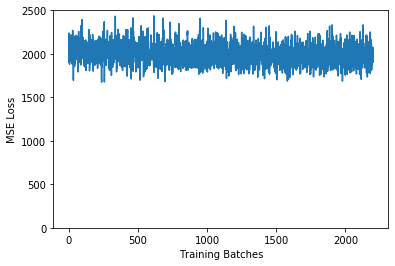

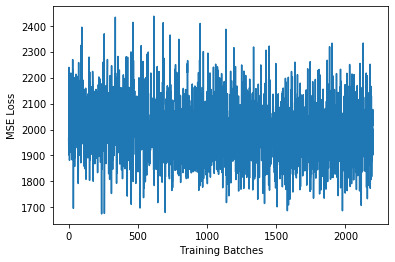

In [22]:
# np.save(os.path.join("..", "saved-data", "biaxial_128_training_losses"), losses)
# np.save(os.path.join("..", "saved-data", "biaxial_128_output_state_matrices"), y_preds.numpy())

(y_preds[0] == y_preds[2]).all()

tensor(False)